In [4]:
!pip install qiskit
!pip install pylatexenc

# Exercise 1: Teleportation

You are given a circuit with two qubits qubit_pair, represented as a tuple of two qubits, in a Bell state. The entangled pair can be in any possible Bell Pair (i.e., starting in |00>, |01>, |10>, or |11> before being entangled). The circuit also has a third qubit, outside_qubit. Write a function that transfers the state from the outside qubit to the second qubit in the Bell pair.

bell_pair_start is a two-character string of 0s or 1s representing the start of the Bell pair before they are entangled.

For ease of grading, please do not add measurement gates to your circuit. It is not explicitly necessary to demonstrate the transfer of state.

In [5]:
def hw4_1_response(circuit, outside_qubit, qubit_pair, bell_pair_start):
  #On nomme nos qubits
  q_source = outside_qubit
  q_alice = qubit_pair[0]
  q_bob = qubit_pair[1]

  #On prépare l'état de Bell
  if bell_pair_start[0] == '1':
    circuit.x(q_alice)
  if bell_pair_start[1] == '1':
    circuit.x(q_bob)

  #On fait l'intrication de nos qubits
  circuit.h(q_alice)
  circuit.cx(q_alice, q_bob)

  #On ajoute une barrière
  circuit.barrier()

  #On commence par la partie d'Alice
  circuit.cx(q_source, q_alice)
  circuit.h(q_source)

  #On ajoute une barrière
  circuit.barrier()

  #On fait la partie de Bob en appliquant les portes nécessaires
  circuit.cx(q_alice, q_bob)
  circuit.cz(q_source, q_bob)

  return circuit


# Exercise 2: Making Gates

Create a function that, given a list of n-bit codes and the length of the code, creates a gate that acts on n+1 qubits, and implements the Archimedes Oracle. Then add it to an n-qubit circuit, and return the circuit from the function.

Remember that a Qiskit uses a different ordering of states, where the top qubit is the least significant qubit when creating bitstrings.

In our convention, the top qubit is the most significant bit, and a Qiskit matrix acting on a three qubit state vector will act on the state vector as if it was [000, 100, 010, 110, 001, 101, 011, 111].

In [11]:
import numpy as np
from qiskit.quantum_info import Operator

def hw4_2_response(circuit, n, codes):

  dim = 2**n

  #On crée la matrice de l'oracle
  oracle_matrix = np.identity(dim, dtype=complex)

  for code in codes:
    # On inverse la chaîne (code[::-1])
    index = int(code[::-1], 2)

    #On applique l'inversion de phase sur la diagonale pour cet index
    oracle_matrix[index, index] = -1

  #On crée un objet Operator à partir de la matrice
  oracle_op = Operator(oracle_matrix)

  circuit.append(oracle_op, range(n))

  return circuit

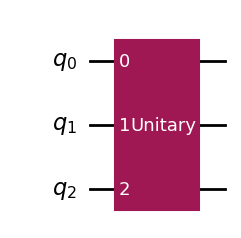

In [13]:
from qiskit import QuantumCircuit

n_qubits = 3
my_circuit = QuantumCircuit(n_qubits)
solutions = ['101', '011']

my_circuit_with_oracle = hw4_2_response(my_circuit, n_qubits, solutions)
my_circuit_with_oracle.draw('mpl')

# Exercise 3: Analyzing Circuits

Write a function that given an n qubit circuit, returns a length n bitstring presenting the code for the Bernstein Vazarani Oracle embedded in the circuit, and the target of the oracle. Your bitstring should use an "x" to represent the location of the target, and 0s and 1s to represent the rest of the code and treat Qubit 0 as the most signficant bit.

The only CX gates included in this circuit are involved in the oracle. You should do this without simulating the circuit, only analyzing the different gates in the circuit.

You can examine the different operations in a circuit with a for loop over the circuit: for i in circuit: and i will be a tuple of the form (operation, qubits, classical bits).

To help examine gates, you can look at the different types of gates [here](https://quantum.cloud.ibm.com/docs/en/api/qiskit/circuit_library).

You may include helper functions if needed.

In [21]:
from qiskit import QuantumCircuit
from collections import Counter

def hw4_3_response(circuit):

  n = circuit.num_qubits
  s_list = ['0'] * n

  cnot_instructions = [
  instr for instr in circuit.data if instr.operation.name == 'cx'
  ]

  if not cnot_instructions:
    return "".join(s_list)

  target_indices = [
  circuit.qubits.index(instr.qubits[1]) for instr in cnot_instructions
  ]

  target_index = Counter(target_indices).most_common(1)[0][0]

  for instruction in cnot_instructions:
    control_index = circuit.qubits.index(instruction.qubits[0])
    s_list[control_index] = '1'

  s_list[target_index] = 'x'

  bitstring = "".join(s_list)

  return bitstring

In [23]:
### TEST Q.3 ###

from qiskit import QuantumCircuit
from collections import Counter

n_qubits = 5
secret_string = '10110'
target_qubit_index = 2
print(f"--- Test du Détecteur d'Oracle BV ---")
print(f"Configuration : n={n_qubits}, secret='{secret_string}', cible=q{target_qubit_index}")

test_circuit = QuantumCircuit(n_qubits)

for i, bit in enumerate(secret_string):
    if bit == '1' and i != target_qubit_index:
        test_circuit.cx(i, target_qubit_index)

print("\nOracle de test construit :")
print(test_circuit.draw(output='text'))

result_string = hw4_3_response(test_circuit)

effective_secret_list = list(secret_string)
if effective_secret_list[target_qubit_index] == '1':
    effective_secret_list[target_qubit_index] = '0'

expected_string_list = list("".join(effective_secret_list))
expected_string_list[target_qubit_index] = 'x'
expected_string = "".join(expected_string_list)


print(f"\n--- Vérification ---")
print(f"Chaîne attendue : {expected_string}")
print(f"Chaîne obtenue   : {result_string}")

--- Test du Détecteur d'Oracle BV ---
Configuration : n=5, secret='10110', cible=q2

Oracle de test construit :
               
q_0: ──■───────
       │       
q_1: ──┼───────
     ┌─┴─┐┌───┐
q_2: ┤ X ├┤ X ├
     └───┘└─┬─┘
q_3: ───────■──
               
q_4: ──────────
               

--- Vérification ---
Chaîne attendue : 10x10
Chaîne obtenue   : 10x10


# Exercise 4: Routing a Circuit

You will be given a random 8 qubit circuit and a connection graph, both as a NetworkX and a dictionary of lists, where the key is a qubit, and the value is a list of qubits it is connected to.

Your goal is to create a function to decompose the circuit to 1 and 2 qubit gates.

Then create a function, using the circuit you just created to recreate the circuit, and add SWAPs as necessary to make sure that the resulting circuit fits the restraints of the connection graph, while still ultimately performing the same actions.

This is a very necessary step of compilation for NISQ era quantum computing, they are sparsely connected, so it is not possible for every qubit to interact with every other qubit. On many machines, 3 qubit gates must be rewritten in terms of their 1 and 2 qubit gate decompositions.
Programming Notes

Qiskit provides many utility "passes" which are algorithms that act on a circuit to analyze, alter or optimize the circuit. These passes work on a Directed Acyclic Graph or DAG, created from the circuit.

To convert a circuit to a DAG use the code snippet dag = qiskit.converters.circuit_to_dag(circuit), and convert a DAG to a circuit with c = qiskit.converters.dag_to_circuit(dag).

To decompose a circuit, you can use the pass found at qiskit.transpiler.passes.Unroll3qOrMore where the documentation can be found [here](https://quantum.cloud.ibm.com/docs/en/api/qiskit/qiskit.transpiler.passes.Unroll3qOrMore).

If you would like, you can use the NetworkX graph with qubits as nodes, or dictionary based graph, with qubits as the keys, and a list of neighboring qubits as the values as the basis of your transformations.

Information for graph algorithms you will need using NetworkX, or other functions can be found here. Specifically, you will likely need:

Neighbors [docs](https://networkx.org/documentation/stable/reference/classes/generated/networkx.Graph.neighbors.html#networkx.Graph.neighbors).

hortest Path [docs](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.shortest_paths.generic.shortest_path.html#networkx.algorithms.shortest_paths.generic.shortest_path) Can be used as nx.shortest_path.

You may include helper functions if needed.